In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install sklearn

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install pydotplus

Note: you may need to restart the kernel to use updated packages.


In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from glob import glob


from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [8]:
df = pd.read_csv('skinCancer/abstract_metadata.csv')
df.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000673,ISIC_0029659,akiec,histo,70,female,face
1,HAM_0005282,ISIC_0025178,akiec,histo,65,male,lower extremity
2,HAM_0006002,ISIC_0029915,akiec,histo,50,female,face
3,HAM_0000549,ISIC_0029360,akiec,histo,70,male,upper extremity
4,HAM_0000549,ISIC_0026152,akiec,histo,70,male,upper extremity
5,HAM_0006875,ISIC_0026575,akiec,histo,80,male,face
6,HAM_0006875,ISIC_0030586,akiec,histo,80,male,face
7,HAM_0002644,ISIC_0029417,akiec,histo,80,female,neck
8,HAM_0005282,ISIC_0028730,akiec,histo,65,male,lower extremity
9,HAM_0006898,ISIC_0029041,akiec,histo,80,male,scalp


In [9]:
df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [10]:
df.count()

lesion_id       700
image_id        700
dx              700
dx_type         700
age             700
sex             700
localization    700
dtype: int64

In [11]:
df['age'].fillna(int(df['age'].mean()),inplace=True)
df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [12]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
base_skin_dir = 'skinCancer'

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [13]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000673,ISIC_0029659,akiec,histo,70,female,face,skinCancer\HAM10000_images_part_2\ISIC_0029659...,Actinic keratoses,0
1,HAM_0005282,ISIC_0025178,akiec,histo,65,male,lower extremity,skinCancer\HAM10000_images_part_1\ISIC_0025178...,Actinic keratoses,0
2,HAM_0006002,ISIC_0029915,akiec,histo,50,female,face,skinCancer\HAM10000_images_part_2\ISIC_0029915...,Actinic keratoses,0
3,HAM_0000549,ISIC_0029360,akiec,histo,70,male,upper extremity,skinCancer\HAM10000_images_part_2\ISIC_0029360...,Actinic keratoses,0
4,HAM_0000549,ISIC_0026152,akiec,histo,70,male,upper extremity,skinCancer\HAM10000_images_part_1\ISIC_0026152...,Actinic keratoses,0


In [14]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((125,100))))

<AxesSubplot:title={'center':'CELL TYPE'}, ylabel='Count'>

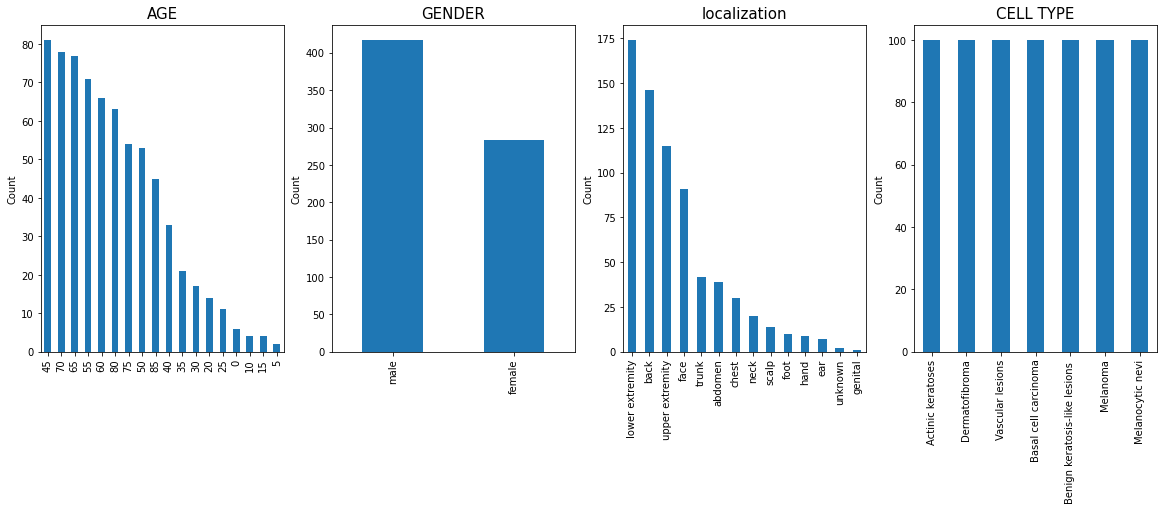

In [15]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(left=0.125, bottom=1, right=0.9, top=2, hspace=0.2)
plt.subplot(2,4,1)
plt.title("AGE",fontsize=15)
plt.ylabel("Count")
df['age'].value_counts().plot.bar()

plt.subplot(2,4,2)
plt.title("GENDER",fontsize=15)
plt.ylabel("Count")
df['sex'].value_counts().plot.bar()

plt.subplot(2,4,3)
plt.title("localization",fontsize=15)
plt.ylabel("Count")
plt.xticks(rotation=45)
df['localization'].value_counts().plot.bar()

plt.subplot(2,4,4)
plt.title("CELL TYPE",fontsize=15)
plt.ylabel("Count")
df['cell_type'].value_counts().plot.bar()

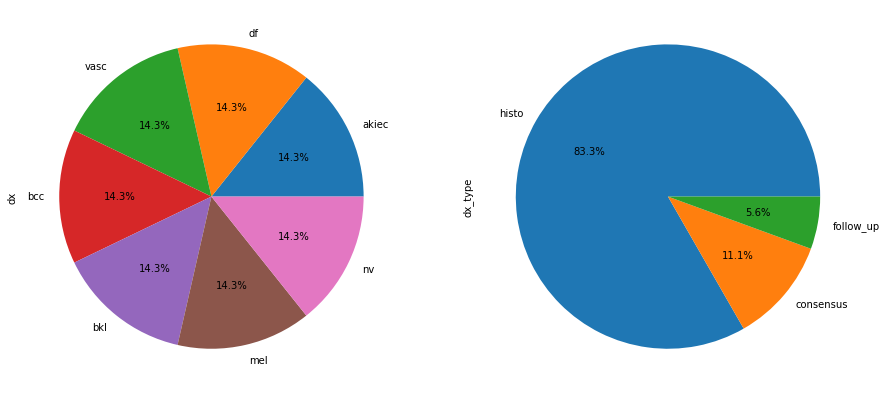

In [16]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
df['dx'].value_counts().plot.pie(autopct="%1.1f%%")
plt.subplot(1,2,2)
df['dx_type'].value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

In [17]:
features=df.drop(columns=['cell_type_idx','image_id'],axis=1)
target=df['cell_type_idx']
features.head()

,lesion_id,dx,dx_type,age,sex,localization,path,cell_type,image
0,HAM_0000673,akiec,histo,70,female,face,skinCancer\HAM10000_images_part_2\ISIC_0029659...,Actinic keratoses,"[[[192, 126, 127], [190, 124, 125], [185, 117,..."
1,HAM_0005282,akiec,histo,65,male,lower extremity,skinCancer\HAM10000_images_part_1\ISIC_0025178...,Actinic keratoses,"[[[209, 169, 180], [211, 169, 178], [210, 170,..."
2,HAM_0006002,akiec,histo,50,female,face,skinCancer\HAM10000_images_part_2\ISIC_0029915...,Actinic keratoses,"[[[27, 15, 13], [30, 15, 15], [32, 16, 16], [3..."
3,HAM_0000549,akiec,histo,70,male,upper extremity,skinCancer\HAM10000_images_part_2\ISIC_0029360...,Actinic keratoses,"[[[16, 7, 12], [19, 8, 12], [20, 9, 12], [22, ..."
4,HAM_0000549,akiec,histo,70,male,upper extremity,skinCancer\HAM10000_images_part_1\ISIC_0026152...,Actinic keratoses,"[[[191, 165, 195], [194, 168, 196], [196, 172,..."


In [18]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size = 0.25,random_state=666)
tf.unique(x_train_o.cell_type.values)

Unique(y=<tf.Tensor: shape=(7,), dtype=string, numpy=
array([b'Melanoma', b'Benign keratosis-like lesions ',
       b'Melanocytic nevi', b'Actinic keratoses', b'Dermatofibroma',
       b'Basal cell carcinoma', b'Vascular lesions'], dtype=object)>, idx=<tf.Tensor: shape=(525,), dtype=int32, numpy=
array([0, 1, 0, 0, 0, 2, 3, 4, 0, 0, 1, 0, 3, 1, 2, 3, 5, 3, 2, 1, 4, 3,
       3, 1, 6, 0, 1, 4, 4, 0, 2, 6, 6, 0, 3, 5, 4, 2, 4, 6, 6, 2, 6, 3,
       1, 6, 2, 4, 3, 2, 5, 4, 1, 5, 1, 6, 2, 5, 3, 2, 5, 0, 0, 0, 4, 6,
       4, 4, 1, 4, 0, 2, 0, 0, 3, 5, 6, 6, 3, 5, 3, 3, 0, 0, 1, 1, 1, 6,
       5, 2, 3, 5, 3, 1, 4, 3, 0, 1, 5, 5, 0, 0, 6, 5, 3, 4, 0, 4, 4, 6,
       6, 4, 3, 4, 0, 5, 6, 1, 2, 5, 2, 3, 5, 4, 5, 0, 0, 2, 2, 3, 0, 6,
       4, 2, 3, 2, 5, 2, 1, 1, 6, 3, 0, 5, 0, 5, 2, 6, 6, 2, 6, 2, 2, 6,
       6, 1, 0, 2, 4, 2, 6, 1, 6, 4, 6, 2, 5, 1, 3, 2, 3, 3, 1, 5, 3, 3,
       4, 0, 2, 3, 5, 5, 1, 3, 3, 5, 4, 6, 0, 6, 3, 5, 6, 4, 0, 2, 2, 1,
       2, 6, 2, 4, 3, 1, 1, 5, 2, 0, 5, 6, 3,

In [19]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)


x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [20]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)
y_test

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [21]:
y_test[1]

array([0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [22]:
y_train

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [23]:
y_test_o.value_counts()

1    28
2    27
3    27
0    25
4    24
6    23
5    21
Name: cell_type_idx, dtype: int64

In [24]:
# x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2, random_state = 20)


# Reshape image in 3 dimensions (height = 100, width = 125 , canal = 3)
x_train = x_train.reshape(x_train_o.shape[0], *(100, 125, 3))
x_test = x_test.reshape(x_test_o.shape[0], *(100, 125, 3))


In [25]:
x_train = x_train.reshape(x_train.shape[0],125*100*3)
x_test = x_test.reshape(x_test.shape[0],125*100*3)
print(x_train.shape)
print(x_test.shape)

(525, 37500)
(175, 37500)


In [26]:
print(x_train)

[[-0.09140732 -0.49162806 -0.46808566 ...  0.23818623 -0.02078013
   0.12047425]
 [ 0.07338946 -0.79767921 -0.09140732 ...  0.04984706 -0.44454326
   0.16755904]
 [-0.11494971 -0.44454326 -0.2091193  ...  0.02630467 -0.42100087
  -0.1855769 ]
 ...
 [ 1.22696689  0.23818623  0.70903416 ...  1.58010283 -0.1855769
   0.54423739]
 [-0.13849211 -0.70350962 -0.65642483 ... -0.32683128 -0.72705202
  -0.75059442]
 [ 1.60364523  0.61486458  0.70903416 ...  1.55656044  0.77966135
   0.77966135]]


### Decision Tree

1
6
11
16
21
26
31
36
41
46


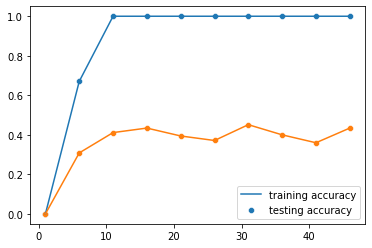

In [27]:
depth = range(1,51,5)
testing_accuracy = []
training_accuracy = []
score = 0

for i in depth:
    tree = DecisionTreeClassifier(max_depth = i, criterion = 'entropy')
    tree.fit(x_train, y_train)
    
    y_predict_train = tree.predict(x_train)
    training_accuracy.append(accuracy_score(y_train, y_predict_train))
    
    y_predict_test = tree.predict(x_test)
    acc_score = accuracy_score(y_test,y_predict_test)
    testing_accuracy.append(acc_score)
    
    print(i)

    if score < acc_score:
        score = acc_score
        best_depth = i
        
sns.lineplot(depth, training_accuracy)
sns.scatterplot(depth, training_accuracy)
sns.lineplot(depth, testing_accuracy)
sns.scatterplot(depth, testing_accuracy)
plt.legend(['training accuracy', 'testing accuracy'])

In [28]:
print('This is the best depth for Decision Tree Classifier: ', best_depth, '\nAccuracy score is: ', score)
result = confusion_matrix(y_test.argmax(axis=1), y_predict_test.argmax(axis=1),)
print("Confusion Matrix:","\n", result)
report = classification_report(y_test.argmax(axis=1), y_predict_test.argmax(axis=1),)
print("Classification Report:" , "\n", report)

This is the best depth for Decision Tree Classifier:  31 
Accuracy score is:  0.4514285714285714
Confusion Matrix: 
 [[15  3  0  1  2  2  2]
 [ 4  9  1  7  2  3  2]
 [ 0  1 14  3  1  5  3]
 [ 6  4  2 10  2  1  2]
 [ 3  6  1  2  7  2  3]
 [ 1  2  3  2  2 11  0]
 [ 1  2  3  2  2  3 10]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.50      0.60      0.55        25
           1       0.33      0.32      0.33        28
           2       0.58      0.52      0.55        27
           3       0.37      0.37      0.37        27
           4       0.39      0.29      0.33        24
           5       0.41      0.52      0.46        21
           6       0.45      0.43      0.44        23

    accuracy                           0.43       175
   macro avg       0.43      0.44      0.43       175
weighted avg       0.43      0.43      0.43       175



### Random Forest

5
10
15
20
25
30
35
40
45
50


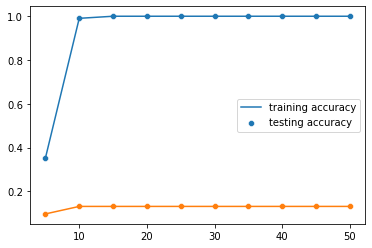

In [29]:
#random Forest
depth = range(5,51,5)
testing_accuracy = []
training_accuracy = []
score = 0

for i in depth:
    tree = RandomForestClassifier(max_depth = i, criterion = 'gini', random_state=6)
    tree.fit(x_train, y_train)
    
    y_predict_train = tree.predict(x_train)
    training_accuracy.append(accuracy_score(y_train, y_predict_train))
    
    y_predict_test = tree.predict(x_test)
    acc_score = accuracy_score(y_test,y_predict_test)
    testing_accuracy.append(acc_score)
    
    print(i)

    if score < acc_score:
        score = acc_score
        best_depth = i
        
sns.lineplot(depth, training_accuracy)
sns.scatterplot(depth, training_accuracy)
sns.lineplot(depth, testing_accuracy)
sns.scatterplot(depth, testing_accuracy)
plt.legend(['training accuracy', 'testing accuracy'])

In [30]:
print('This is the best depth for Decision Tree Classifier: ', best_depth, '\nAccuracy score is: ', score)
result = confusion_matrix(y_test.argmax(axis=1), y_predict_test.argmax(axis=1),)
print("Confusion Matrix:","\n", result)
report = classification_report(y_test.argmax(axis=1), y_predict_test.argmax(axis=1),)
print("Classification Report:" , "\n", report)

This is the best depth for Decision Tree Classifier:  10 
Accuracy score is:  0.13142857142857142
Confusion Matrix: 
 [[25  0  0  0  0  0  0]
 [25  2  0  0  1  0  0]
 [15  0  6  0  0  6  0]
 [26  0  0  1  0  0  0]
 [19  0  0  0  5  0  0]
 [15  0  2  0  0  4  0]
 [19  0  0  0  0  0  4]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.17      1.00      0.30        25
           1       1.00      0.07      0.13        28
           2       0.75      0.22      0.34        27
           3       1.00      0.04      0.07        27
           4       0.83      0.21      0.33        24
           5       0.40      0.19      0.26        21
           6       1.00      0.17      0.30        23

    accuracy                           0.27       175
   macro avg       0.74      0.27      0.25       175
weighted avg       0.75      0.27      0.24       175



### KNN

1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
31
33
35
37
39
41
43
45
47
49
51
53
55
57
59
61
63
65
67
69
71
73
75
77
79
81
83
85
87
89
91
93
95
97
99
101
103
105
107
109
111
113
115
117
119
121
123
125
127
129
131
133
135
137
139
141
143
145
147
149
151
153
155
157
159
161
163
165
167
169
171
173
175
177
179
181
183
185
187
189
191
193
195
197
199
201
203
205
207
209
211
213
215
217
219
221
223
225
227
229
231
233
235
237
239
241
243
245
247
249
251
253
255
257
259
261
263
265
267
269
271
273
275
277
279
281
283
285
287
289
291
293
295
297
299
301
303
305
307
309
311
313
315
317
319
321
323
325
327
329
331
333
335
337
339
341
343
345
347
349
351
353
355
357
359
361
363
365
367
369
371
373
375
377
379
381
383
385
387
389
391
393
395
397
399
401
403
405
407
409
411
413
415
417
419
421
423
425
427
429
431
433
435
437
439
441
443
445
447
449
451
453
455
457
459
461
463
465
467
469
471
473
475
477
479
481
483
485
487
489
491
493
495
497
499


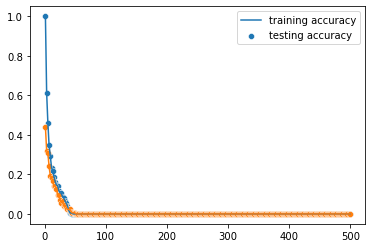

In [31]:
k = range(1,500,2)
testing_accuracy = []
training_accuracy = []
score = 0

for i in k:
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(x_train, y_train)
    
    y_predict_train = knn.predict(x_train)
    training_accuracy.append(accuracy_score(y_train, y_predict_train))
    
    y_predict_test = knn.predict(x_test)
    acc_score = accuracy_score(y_test,y_predict_test)
    testing_accuracy.append(acc_score)
    
    print(i)

    if score < acc_score:
        score = acc_score
        best_k = i
        
        
sns.lineplot(k, training_accuracy)
sns.scatterplot(k, training_accuracy)
sns.lineplot(k, testing_accuracy)
sns.scatterplot(k, testing_accuracy)
plt.legend(['training accuracy', 'testing accuracy'])

In [32]:
'''print('This is the best depth for Decision Tree Classifier: ', best_depth, '\nAccuracy score is: ', score)'''
result = confusion_matrix(y_test.argmax(axis=1), y_predict_test.argmax(axis=1),)
print("Confusion Matrix:","\n", result)
report = classification_report(y_test.argmax(axis=1), y_predict_test.argmax(axis=1),)
print("Classification Report:" , "\n", report)

Confusion Matrix: 
 [[25  0  0  0  0  0  0]
 [28  0  0  0  0  0  0]
 [27  0  0  0  0  0  0]
 [27  0  0  0  0  0  0]
 [24  0  0  0  0  0  0]
 [21  0  0  0  0  0  0]
 [23  0  0  0  0  0  0]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.14      1.00      0.25        25
           1       0.00      0.00      0.00        28
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        27
           4       0.00      0.00      0.00        24
           5       0.00      0.00      0.00        21
           6       0.00      0.00      0.00        23

    accuracy                           0.14       175
   macro avg       0.02      0.14      0.04       175
weighted avg       0.02      0.14      0.04       175



In [33]:
x_train = x_train.reshape(x_train_o.shape[0], *(100, 125, 3))
x_test = x_test.reshape(x_test_o.shape[0], *(100, 125, 3))
x_train.shape

(525, 100, 125, 3)

### MLP

In [36]:
x_train = x_train.reshape(x_train.shape[0],125*100*3)
x_test = x_test.reshape(x_test.shape[0],125*100*3)

# define the keras model
model = Sequential()

model.add(Dense(units= 128, kernel_initializer = 'uniform', activation = 'relu', input_dim = 37500))
model.add(Dense(units= 256, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units= 512, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               4800128   
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dense_7 (Dense)             (None, 512)               131584    
                                                                 
 dense_8 (Dense)             (None, 64)                32832     
                                                                 
 dense_9 (Dense)             (None, 7)                 455       
                                                                 
Total params: 4,998,023
Trainable params: 4,998,023
Non-trainable params: 0
_________________________________________________________________


In [37]:
# compile the keras model
model.compile(optimizer = "Adam", loss = 'categorical_crossentropy', metrics = ['accuracy'])

# fit the keras model on the dataset
history = model.fit(x_train, y_train, batch_size = 500, epochs = 25)

Epoch 1/25
2/2 [==============================] - 1s 29ms/step - loss: 1.9491 - accuracy: 0.1257
Epoch 2/25
2/2 [==============================] - 0s 13ms/step - loss: 1.8978 - accuracy: 0.1905
Epoch 3/25
2/2 [==============================] - 0s 13ms/step - loss: 1.7399 - accuracy: 0.3390
Epoch 4/25
2/2 [==============================] - 0s 13ms/step - loss: 1.6039 - accuracy: 0.3562
Epoch 5/25
2/2 [==============================] - 0s 12ms/step - loss: 1.4988 - accuracy: 0.3524
Epoch 6/25
2/2 [==============================] - 0s 15ms/step - loss: 1.4950 - accuracy: 0.3657
Epoch 7/25
2/2 [==============================] - 0s 13ms/step - loss: 1.3831 - accuracy: 0.4000
Epoch 8/25
2/2 [==============================] - 0s 12ms/step - loss: 1.3151 - accuracy: 0.4495
Epoch 9/25
2/2 [==============================] - 0s 14ms/step - loss: 1.3002 - accuracy: 0.4705
Epoch 10/25
2/2 [==============================] - 0s 14ms/step - loss: 1.2552 - accuracy: 0.4933
Epoch 11/25
2/2 [============

In [38]:
accuracy = model.evaluate(x_test, y_test, verbose=1)[1]
print("Test: accuracy = ",accuracy*100,"%")

6/6 [==============================] - 0s 5ms/step - loss: 1.7181 - accuracy: 0.3543
Test: accuracy =  35.428571701049805 %


### CNN

In [39]:
x_train = x_train.reshape(x_train.shape[0], 125,100,3)
x_test = x_test.reshape(x_test.shape[0], 125, 100, 3)
print(x_train.shape)
print(x_test.shape)

(525, 125, 100, 3)
(175, 125, 100, 3)


In [40]:
input_shape = (125, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(64,kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.16))

model.add(Conv2D(128, (3, 3), activation='relu',padding = 'same'))
model.add(Conv2D(128, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.20))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 100, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 50, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 62, 50, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 62, 50, 128)       147584    
                                                      

In [41]:
model.compile(optimizer= "Adam",
            loss='categorical_crossentropy',
            metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
#x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 999)


# Reshape image in 3 dimensions (height = 100, width = 125 , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(125, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(125, 100, 3))
#x_validate = x_validate.reshape(x_validate.shape[0], *(100, 125, 3))

tf.config.run_functions_eagerly(True)


model.fit(x_train, y_train, batch_size = 500, epochs = 10)

Epoch 1/10
2/2 [==============================] - 23s 1s/step - loss: 2.8459 - accuracy: 0.1181
Epoch 2/10
2/2 [==============================] - 22s 1s/step - loss: 4.6677 - accuracy: 0.1619
Epoch 3/10
2/2 [==============================] - 22s 1s/step - loss: 2.0321 - accuracy: 0.2095
Epoch 4/10
2/2 [==============================] - 22s 1s/step - loss: 1.9045 - accuracy: 0.2305
Epoch 5/10
2/2 [==============================] - 22s 1s/step - loss: 1.9055 - accuracy: 0.2305
Epoch 6/10
2/2 [==============================] - 22s 1s/step - loss: 1.8571 - accuracy: 0.2438
Epoch 7/10
2/2 [==============================] - 22s 1s/step - loss: 1.8045 - accuracy: 0.2629
Epoch 8/10


In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Accuracy: ",test_acc*100,"%")